# Label Analysis

In this notebook we analyse the datsets and label distributions we get for different settings for sampling and labeling strategy.

In [11]:
%reload_ext autoreload
%autoreload 2
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datasets import HighQualityFallDataset
from datasets.transforms.label_strategy import HQFD_LABEL_DESCRIPTION, PriorityLabel
from datasets.transforms.sampling_strategy import GaussianSampling, UniformSampling

In [12]:
ANN_FILE = "data/Fall_Simulation_Data/annotations_train.csv"

uniform_sampling = UniformSampling(clip_len=10, stride=0, overlap=False)
gaussian_sampling = GaussianSampling(
    clip_len=10, n_samples_per_sec=None, fallback_sampler=None, std=None
)
label_strategy = PriorityLabel(
    label_description=HQFD_LABEL_DESCRIPTION,
    threshold=0.0,
    absolute_threshold=False,
    priority=[0, 1, 2],
)

hqfd = HighQualityFallDataset(
    ann_file=ANN_FILE,
    sampling_strategy=gaussian_sampling,
    label_strategy=label_strategy,
    pipeline=[],
    num_classes=3,
    test_mode=False,
    drop_ratios=[0.0, 0.0, 0.75],
)

df_hqfd = pd.DataFrame(list(hqfd))
class_names = ["Fall", "Lying", "Other"]
df_hqfd["label_name"] = df_hqfd["label"].apply(lambda x: class_names[x])


def extract_category(filename):
    match = re.search(r"(ADL|Fall)", filename.split("/")[-1])
    return match.group(1) if match else None


df_hqfd["video_category"] = df_hqfd["filename"].apply(extract_category)

df_hqfd.head()

,filename,label,interval,sample_idx,modality,start_index,label_name,video_category
0,data/Fall_Simulation_Data/videos/ADL17_Cam1.avi,2,"(30.0, 40.0)",0,RGB,0,Fall,Fall
1,data/Fall_Simulation_Data/videos/ADL17_Cam1.avi,2,"(50.0, 60.0)",1,RGB,0,Lying,Fall
2,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,2,"(60.0, 70.0)",2,RGB,0,Other,Fall
3,data/Fall_Simulation_Data/videos/ADL17_Cam1.avi,2,"(90.0, 100.0)",3,RGB,0,Lying,Fall
4,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,2,"(160.0, 170.0)",4,RGB,0,Other,Fall


In [13]:
def plot_label_dist(df_hqfd):
    display("---- Label Distribution ----")
    display(df_hqfd["label_name"].value_counts().sort_index() / len(df_hqfd))

    display("---- Label Counts ----")
    display(df_hqfd["label_name"].value_counts().sort_index())
    df_hqfd["label_name"].value_counts().sort_index().plot(kind="bar")
    plt.show()

'---- Label Distribution ----'

label_name
Fall     0.288679
Lying    0.204657
Other    0.506664
Name: count, dtype: float64

'---- Label Counts ----'

label_name
Fall     1711
Lying    1213
Other    3003
Name: count, dtype: int64

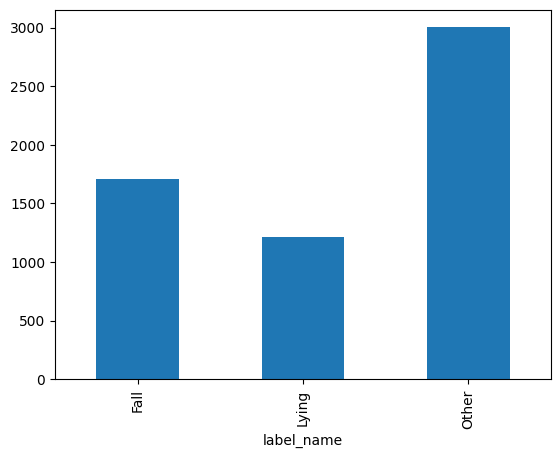

In [14]:
plot_label_dist(df_hqfd)

'---- Label Distribution ----'

label_name
Fall     0.525330
Lying    0.372429
Other    0.102241
Name: count, dtype: float64

'---- Label Counts ----'

label_name
Fall     1711
Lying    1213
Other     333
Name: count, dtype: int64

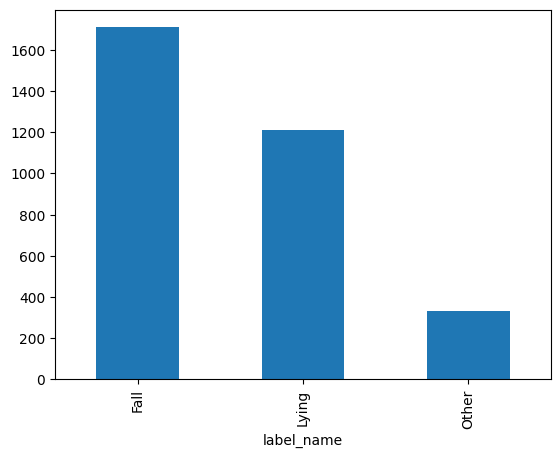

In [15]:
plot_label_dist(df_hqfd[df_hqfd["video_category"] == "Fall"])

# Class weight calculation

weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

In [13]:
weights = []
num_classes = 3
for i in range(num_classes):
    total_samples = len(df_hqfd)
    num_samples_in_class_i = len(df_hqfd[df_hqfd["label"] == i])
    weights.append(total_samples / num_samples_in_class_i * num_classes)

display(weights)

[26.38235294117647, 37.901408450704224, 3.7168508287292816]